**Import Libraries**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import datetime
from datetime import date
import random

import warnings

warnings.filterwarnings('ignore')

**Import Data**

In [2]:
data = pd.read_csv('./data/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [3]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [5]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [6]:
ts = data['2018-03-30':'2018-09-29']

In [7]:
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2018-03-30 00:00:00,None,272.30,0.0,0.0,1,Clear,sky is clear,2018-03-30 00:00:00,817
2018-03-30 01:00:00,None,271.93,0.0,0.0,1,Clear,sky is clear,2018-03-30 01:00:00,413
2018-03-30 02:00:00,None,271.22,0.0,0.0,1,Clear,sky is clear,2018-03-30 02:00:00,329
2018-03-30 03:00:00,None,270.09,0.0,0.0,1,Clear,sky is clear,2018-03-30 03:00:00,359
2018-03-30 04:00:00,None,269.65,0.0,0.0,1,Clear,sky is clear,2018-03-30 04:00:00,749


In [8]:
ts.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,5430.000000,5430.000000,5430.0,5430.000000,5430.00000
mean,290.070619,0.178206,0.0,44.658011,3296.05267
std,9.153027,0.748593,0.0,38.832373,1985.41250
min,259.650000,0.000000,0.0,0.000000,151.00000
25%,287.020000,0.000000,0.0,1.000000,1249.25000
50%,292.080000,0.000000,0.0,40.000000,3446.00000
75%,295.925000,0.000000,0.0,90.000000,4942.75000
max,310.070000,10.600000,0.0,92.000000,7213.00000


In [9]:
split_date = '2018-08-30'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [11]:
x_train = np.array(ts_train['traffic_volume'])
x_valid = np.array(ts_test['traffic_volume'])
series = np.concatenate((x_train, x_valid), axis=0)

time_train = np.array(ts_train['date_time'])
time_valid = np.array(ts_test['date_time'])
time = np.concatenate((time_train, time_valid), axis=0)

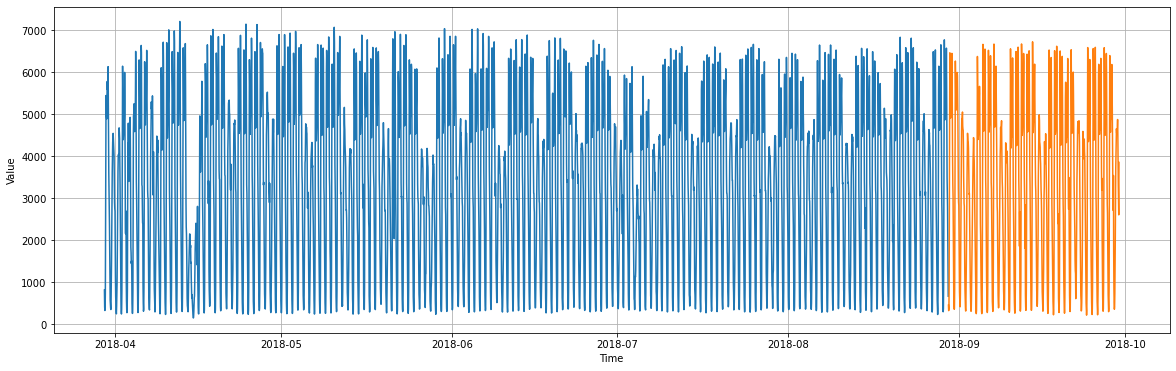

In [12]:
plt.figure(figsize=(20, 6))
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)


In [13]:
print(len(time_train))
print(len(x_train))
print(len(time_valid))
print(len(x_valid))

4462
4462
968
968


In [14]:
window_size = 24
batch_size = 128
shuffle_buffer_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# LSTM

In [17]:
tf.keras.backend.clear_session()

##
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    #tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L1(0.001)),
    tf.keras.layers.Lambda(lambda x: x * 8000)

])

In [18]:
%%bash
rm -rf ./logs/

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10, restore_best_weights=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [20]:
history = model.fit(train_set,validation_data=valid_set, epochs=300, callbacks=[es, rp, tb]) 

Epoch 1/300
35/35 [==============================] - 12s 96ms/step - loss: 2475.8867 - mae: 2476.3848 - val_loss: 3375.6948 - val_mae: 3376.1929 - lr: 0.0010
Epoch 2/300
35/35 [==============================] - 2s 47ms/step - loss: 750.4540 - mae: 750.9514 - val_loss: 1308.7311 - val_mae: 1309.2288 - lr: 0.0010
Epoch 3/300
35/35 [==============================] - 2s 45ms/step - loss: 518.6762 - mae: 519.1738 - val_loss: 718.7319 - val_mae: 719.2296 - lr: 0.0010
Epoch 4/300
35/35 [==============================] - 1s 34ms/step - loss: 443.4835 - mae: 443.9810 - val_loss: 550.6990 - val_mae: 551.1967 - lr: 0.0010
Epoch 5/300
35/35 [==============================] - 1s 34ms/step - loss: 400.1923 - mae: 400.6899 - val_loss: 398.8296 - val_mae: 399.3272 - lr: 0.0010
Epoch 6/300
35/35 [==============================] - 1s 33ms/step - loss: 369.5819 - mae: 370.0794 - val_loss: 322.9011 - val_mae: 323.3986 - lr: 0.0010
Epoch 7/300
35/35 [==============================] - 1s 33ms/step - loss: 3

Epoch 54/300
35/35 [==============================] - 1s 36ms/step - loss: 189.8885 - mae: 190.3855 - val_loss: 100.4582 - val_mae: 100.9540 - lr: 1.0000e-04
Epoch 55/300
35/35 [==============================] - 1s 34ms/step - loss: 190.0551 - mae: 190.5520 - val_loss: 106.4813 - val_mae: 106.9777 - lr: 1.0000e-04
Epoch 56/300
35/35 [==============================] - 1s 35ms/step - loss: 184.5096 - mae: 185.0064 - val_loss: 108.7634 - val_mae: 109.2602 - lr: 1.0000e-04
Epoch 57/300
35/35 [==============================] - 1s 34ms/step - loss: 190.9877 - mae: 191.4848 - val_loss: 99.5254 - val_mae: 100.0213 - lr: 1.0000e-04
Epoch 58/300
35/35 [==============================] - 1s 35ms/step - loss: 188.3993 - mae: 188.8961 - val_loss: 101.8809 - val_mae: 102.3772 - lr: 1.0000e-04
Epoch 59/300
35/35 [==============================] - 1s 34ms/step - loss: 187.3832 - mae: 187.8801 - val_loss: 105.5839 - val_mae: 106.0804 - lr: 1.0000e-04
Epoch 60/300
35/35 [==============================] -

35/35 [==============================] - 1s 36ms/step - loss: 179.7698 - mae: 180.2668 - val_loss: 88.8986 - val_mae: 89.3945 - lr: 1.0000e-04
Epoch 107/300
35/35 [==============================] - 1s 37ms/step - loss: 177.6982 - mae: 178.1952 - val_loss: 91.2771 - val_mae: 91.7732 - lr: 1.0000e-04
Epoch 108/300
35/35 [==============================] - 1s 35ms/step - loss: 179.5907 - mae: 180.0878 - val_loss: 89.5961 - val_mae: 90.0919 - lr: 1.0000e-04
Epoch 109/300
35/35 [==============================] - 1s 34ms/step - loss: 179.6664 - mae: 180.1631 - val_loss: 91.8070 - val_mae: 92.3032 - lr: 1.0000e-04
Epoch 110/300
35/35 [==============================] - 1s 33ms/step - loss: 182.8034 - mae: 183.3004 - val_loss: 92.5737 - val_mae: 93.0695 - lr: 1.0000e-04
Epoch 111/300
35/35 [==============================] - 1s 35ms/step - loss: 178.0272 - mae: 178.5241 - val_loss: 91.4664 - val_mae: 91.9625 - lr: 1.0000e-04
Epoch 112/300
35/35 [==============================] - 1s 34ms/step - lo

In [21]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 6824), started 1:12:55 ago. (Use '!kill 6824' to kill it.)

In [22]:
### summarize history for loss
split_time = 4462
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

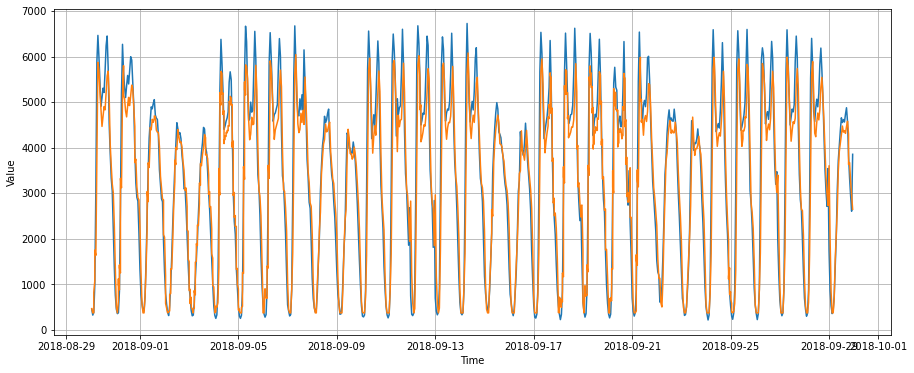

In [23]:
plt.figure(figsize=(15, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

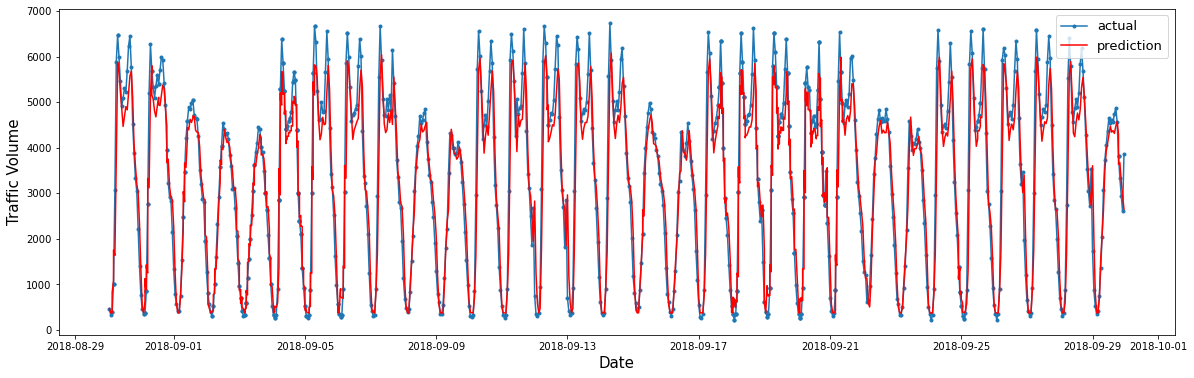

In [24]:
plt.figure(figsize=(20,6))
plt.plot(time_valid, x_valid, marker='.', label="actual")
plt.plot(time_valid, rnn_forecast, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

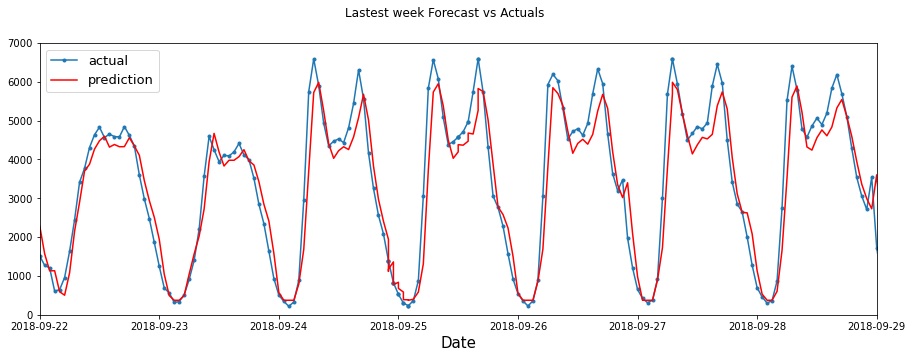

In [25]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(time_valid, x_valid, marker='.', label="actual")
plt.plot(time_valid, rnn_forecast, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

In [26]:
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

mae = tf.keras.metrics.mae(x_valid, rnn_forecast).numpy()
mape = tf.keras.metrics.mape(x_valid, rnn_forecast).numpy()
mse = tf.keras.metrics.mse(x_valid, rnn_forecast).numpy()
rmse = rmse(x_valid, rnn_forecast).numpy()
print(' MAE : {:.2f}'.format(mae))
print(' MAPE : {:.2f} %'.format(mape))
print(' RMSE : {:.2f}'.format(rmse))

 MAE : 447.30
 MAPE : 21.50 %
 RMSE : 624.53
